### Try out the Phase Modulator in TorchOptics

In [2]:
# imports
import torch
import torchoptics
import matplotlib.pyplot as plt

from torchoptics import Field, System, Param
from torchoptics.elements import PhaseModulator
from torchoptics.profiles import gaussian

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Set code to run on GPU

shape = 250 # 250x250 grid for the simulation
waist_radius = 150e-6 # Thickness of the gaussian

# Configure torchoptics default properties
torchoptics.set_default_spacing(10e-6) # Spacing between grid points
torchoptics.set_default_wavelength(700e-9) # Wavelength of monochromatic field

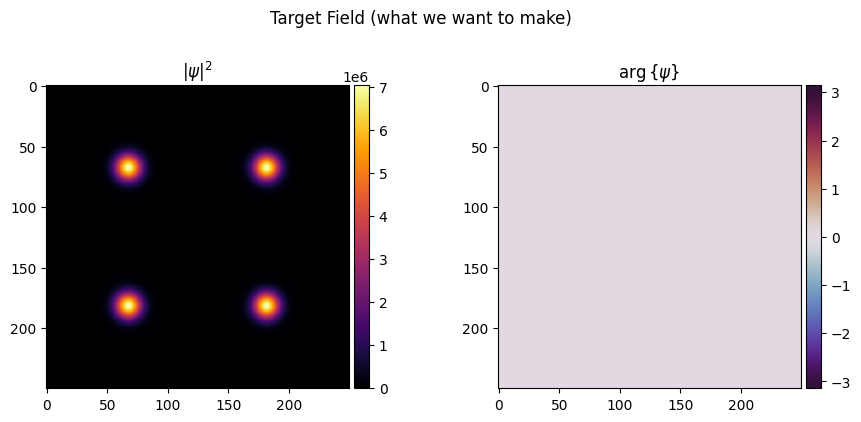

In [4]:
# Form the target field (what we want to make)
target_field_data = (gaussian(shape, waist_radius, offset=(3.8*waist_radius, 3.8*waist_radius))
                     + gaussian(shape, waist_radius, offset=(-3.8*waist_radius, 3.8*waist_radius))
                     + gaussian(shape, waist_radius, offset=(3.8*waist_radius, -3.8*waist_radius))
                     + gaussian(shape, waist_radius, offset=(-3.8*waist_radius, -3.8*waist_radius)))/2

# Convert the data into the Field class
target_field = Field(target_field_data, z=0.6).to(device)
target_field.visualize(title="Target Field (what we want to make)")

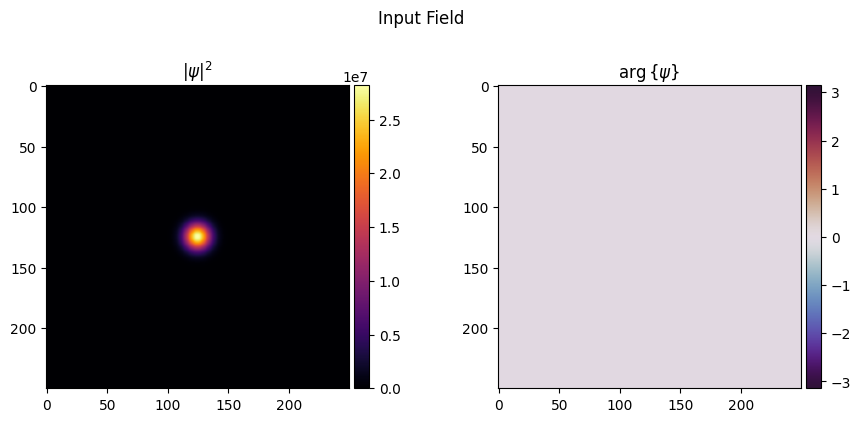

In [5]:
# Make the input field a singular gaussian
input_field = Field(gaussian(shape, waist_radius), z=0).to(device)
input_field.visualize(title="Input Field")

In [6]:
# Create a system (sequence of elements) that the field will propagate through
system = System(PhaseModulator(Param(torch.zeros(shape,shape)), z=0.0),
                PhaseModulator(Param(torch.zeros(shape,shape)), z=0.2),
                PhaseModulator(Param(torch.zeros(shape,shape)), z=0.4)).to(device)

In [7]:
# Train the parameters in the PhaseModulators to give an output close to the target.
optimiser = torch.optim.Adam(system.parameters(), lr=0.1)
losses = [] # Create a list to graph later

for iteration in range(1,401):
    optimiser.zero_grad() # Type of optimisation
    output_field = system.measure_at_z(input_field, 0.6) # Measure input field after it propagates through the system to z=0.6

    # Calculate losses
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

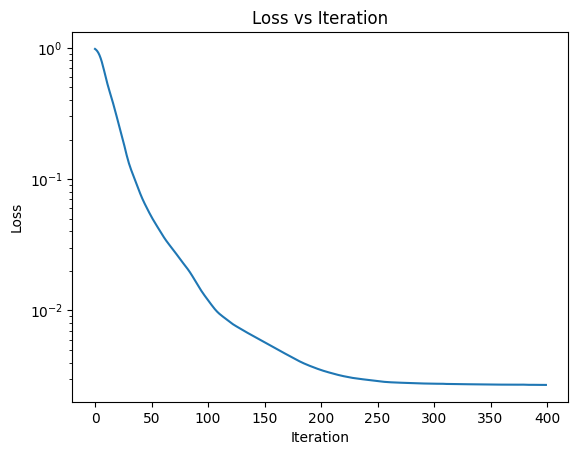

In [8]:
# Plot losses data
plt.plot(losses)

# Make it look nice
plt.title("Loss vs Iteration")
plt.xlabel("Iteration"), plt.ylabel("Loss")
plt.yscale("log") # Logarithmic scale
plt.show()

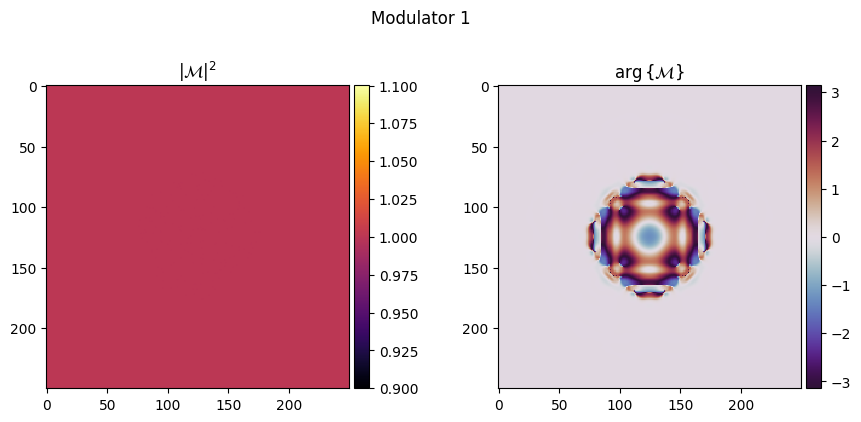

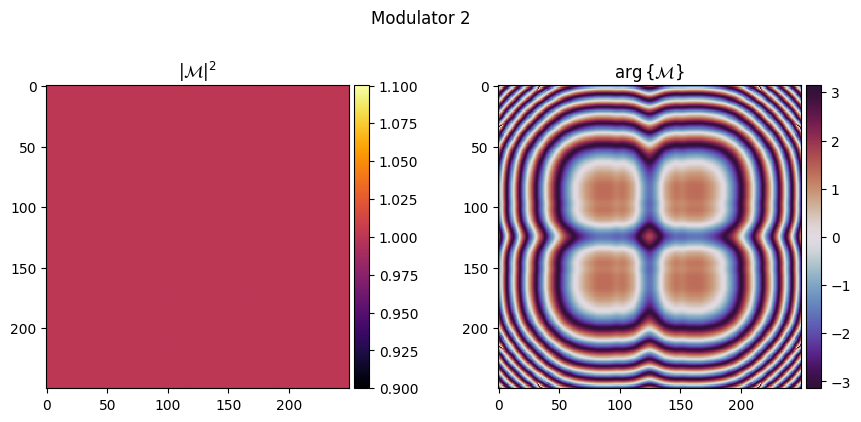

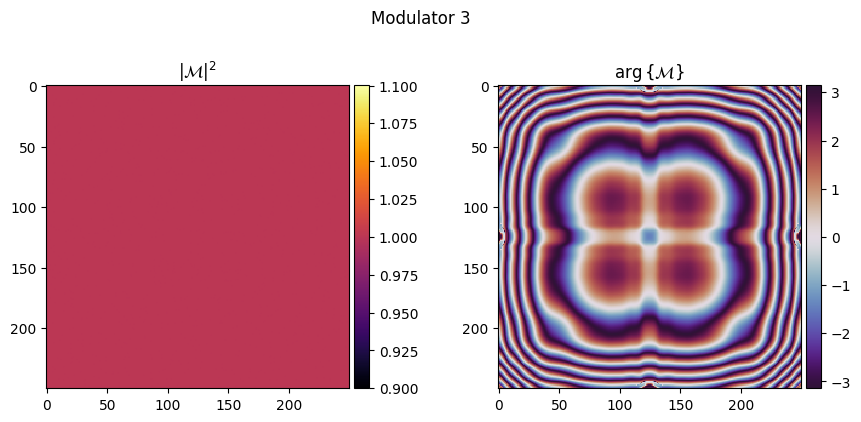

In [9]:
# Visualise the modulators that have been produced
for i, element in enumerate(system):
    element.visualize(title=f"Modulator {i+1}")

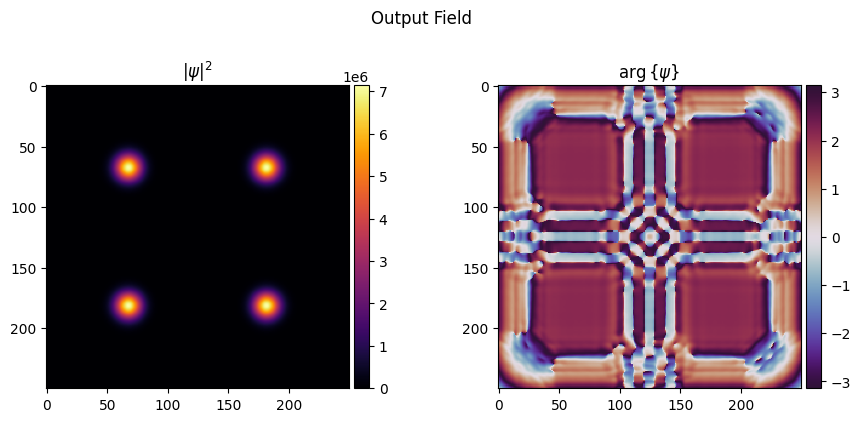

In [10]:
output_field = system.measure_at_z(input_field, z=0.6)
output_field.visualize(title="Output Field")

## Try using the phase modulators with different input fields and target fields
Make a square field split into 4, similar to the gaussians

In [11]:
from torchoptics.profiles import square
from torchoptics.profiles import circle
from torchoptics.profiles import sinc

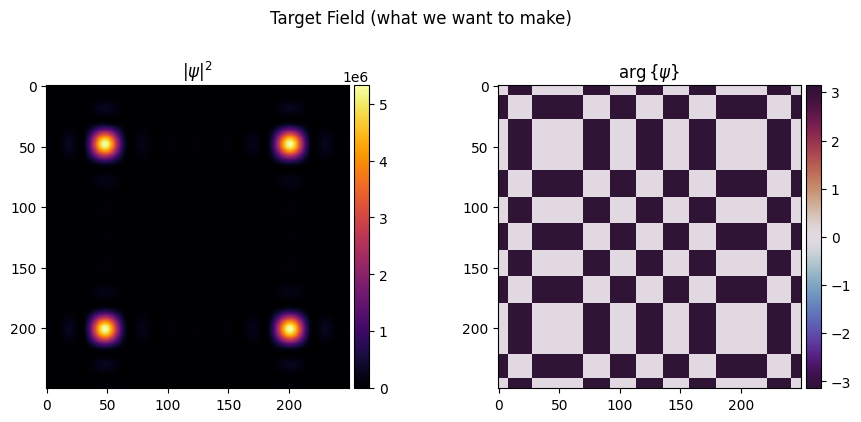

In [12]:
# Form the target field (what we want to make)
target_field_sq_data = (sinc(shape, 200e-6, offset=(3.8*200e-6, 3.8*200e-6)) 
                     + sinc(shape, 200e-6, offset=(-3.8*200e-6, 3.8*200e-6)) 
                     + sinc(shape, 200e-6, offset=(3.8*200e-6, -3.8*200e-6)) 
                     + sinc(shape, 200e-6, offset=(-3.8*200e-6, -3.8*200e-6)))/2

# Convert the data into the Field class
target_field_sq = Field(target_field_sq_data, z=0.6).to(device)
target_field_sq.visualize(title="Target Field (what we want to make)")

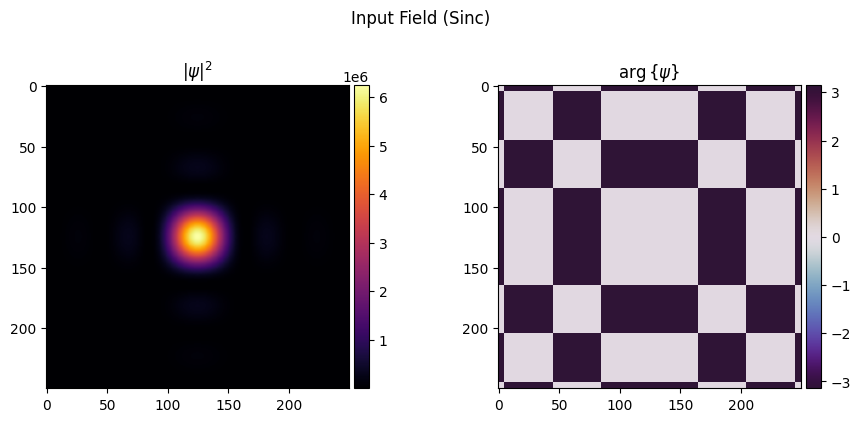

In [13]:
# Make the input field a single square
input_field_sq = Field(sinc(shape, 400e-6), z=0).to(device)
input_field_sq.visualize(title="Input Field (Sinc)")

In [14]:
# Create a system (sequence of elements) that the field will propagate through
system_sq = System(PhaseModulator(Param(torch.zeros(shape,shape)), z=0.0),
                PhaseModulator(Param(torch.zeros(shape,shape)), z=0.2),
                PhaseModulator(Param(torch.zeros(shape,shape)), z=0.4)).to(device)

In [15]:
# Train the parameters in the PhaseModulators to give an output close to the target.
optimiser_sq = torch.optim.Adam(system_sq.parameters(), lr=0.1)
losses = [] # Create a list to graph later

for iteration in range(1,401):
    optimiser_sq.zero_grad() # Type of optimisation
    output_field_sq = system_sq.measure_at_z(input_field_sq, 0.6) # Measure input field after it propagates through the system to z=0.6

    # Calculate losses
    loss = 1 - output_field_sq.inner(target_field_sq).abs().square()
    loss.backward()
    optimiser_sq.step()
    losses.append(loss.item())

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss {loss.item()}")

Iteration 10, Loss 0.8483842227024465
Iteration 20, Loss 0.5851373291643933
Iteration 30, Loss 0.40221100601524595
Iteration 40, Loss 0.3280946329011113
Iteration 50, Loss 0.29505643551868543
Iteration 60, Loss 0.27775502912295935
Iteration 70, Loss 0.26675263626314905
Iteration 80, Loss 0.2575357597029414
Iteration 90, Loss 0.252708770177858
Iteration 100, Loss 0.24954632501495688
Iteration 110, Loss 0.24749042529376575
Iteration 120, Loss 0.24579638268731208
Iteration 130, Loss 0.24453065796581974
Iteration 140, Loss 0.24347386272888694
Iteration 150, Loss 0.2426665034614418
Iteration 160, Loss 0.24201252723889333
Iteration 170, Loss 0.2414859593893911
Iteration 180, Loss 0.2410696988078581
Iteration 190, Loss 0.24068602301421338
Iteration 200, Loss 0.2403787646960064
Iteration 210, Loss 0.24009214784900523
Iteration 220, Loss 0.23981816505747344
Iteration 230, Loss 0.23954737270870907
Iteration 240, Loss 0.23924573482002587
Iteration 250, Loss 0.2388207856289527
Iteration 260, Loss 

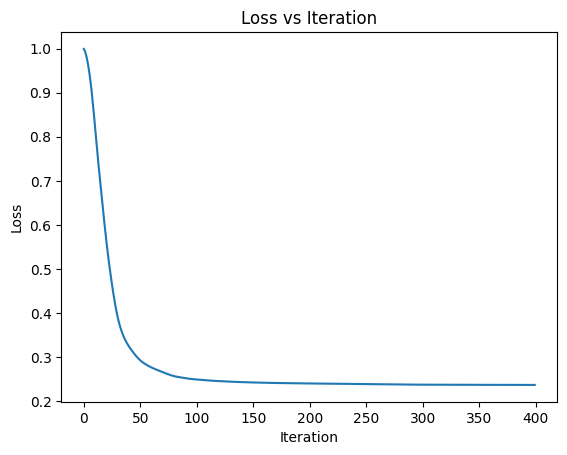

In [16]:
# Plot losses data
plt.plot(losses)

# Make it look nice
plt.title("Loss vs Iteration")
plt.xlabel("Iteration"), plt.ylabel("Loss")
#plt.yscale("log") # Logarithmic scale
plt.show()

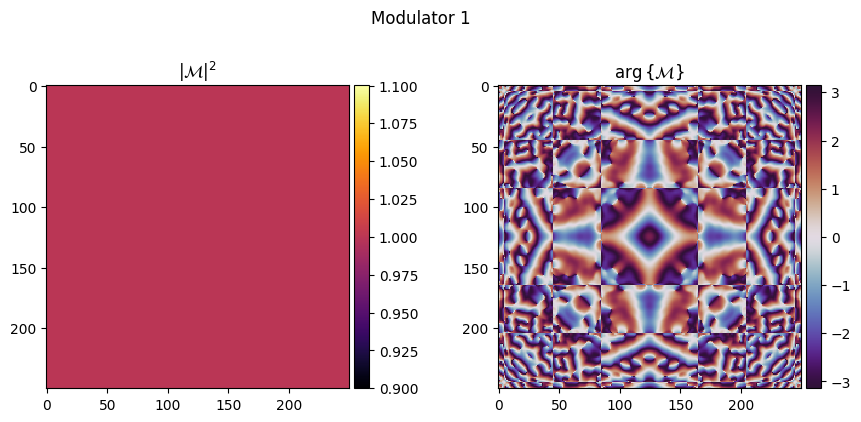

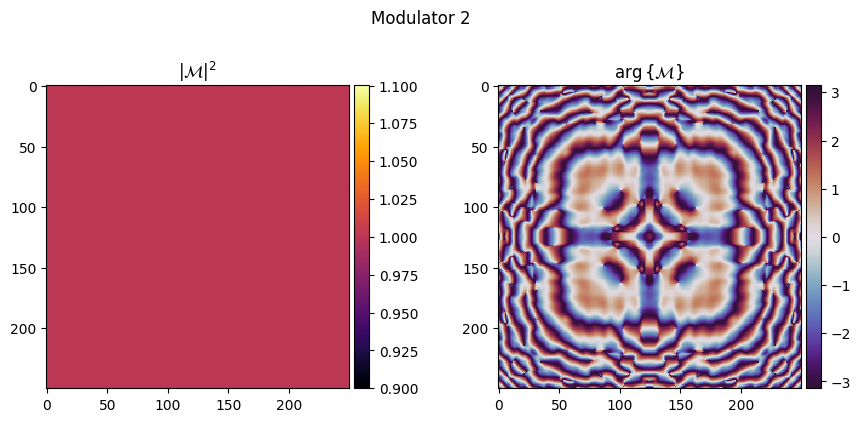

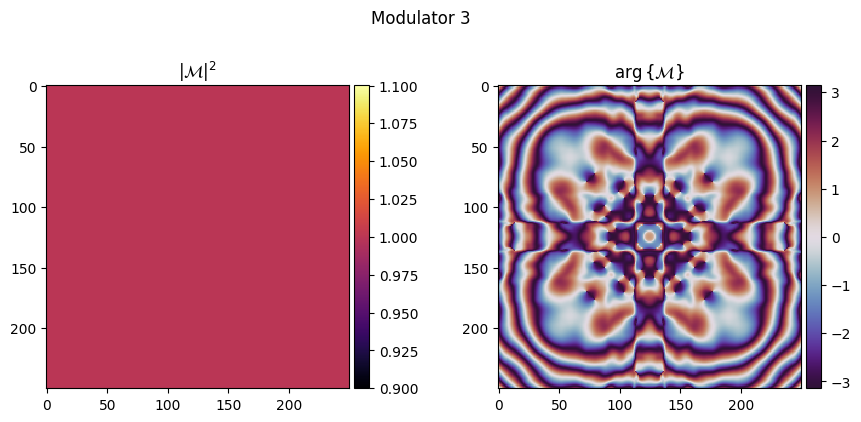

In [17]:
# Visualise the modulators that have been produced
for i, element in enumerate(system_sq):
    element.visualize(title=f"Modulator {i+1}")

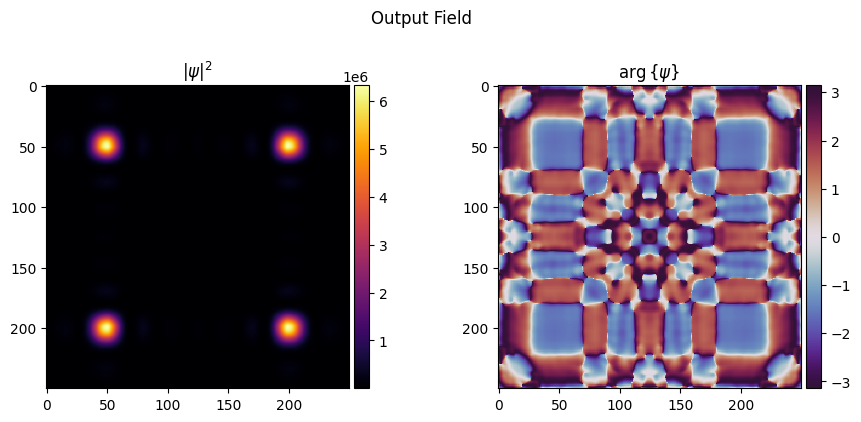

In [18]:
output_field_sq = system_sq.measure_at_z(input_field_sq, z=0.6)
output_field_sq.visualize(title="Output Field")